# Лабораторна робота 5. Аналіз даних даних і візуалізація Pyspark
## Авдєєва Серафима ФІТ 4-4

In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt

In [3]:
# Ініціалізація Spark сесії
spark = SparkSession.builder.appName("amazon_books").getOrCreate()

In [4]:
# Читання CSV файлу
df = spark.read.csv("/content/sample_data/bestsellers_with_categories.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [6]:
# Вивести назви стовпців і типи даних:
print(df.dtypes)

[('Name', 'string'), ('Author', 'string'), ('User Rating', 'double'), ('Reviews', 'int'), ('Price', 'int'), ('Year', 'int'), ('Genre', 'string')]


In [7]:
# Виведіть перші п'ять рядків:
df.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating=4.6, Reviews=2052, Price=22, Year=2011, Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating=4.7, Reviews=18979, Price=15, Year=2018, Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating=4.7, Reviews=21424, Price=6, Year=2017, Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating=4.8, Reviews=7665, Price=12, Year=2019, Genre='Non Fiction')]

In [8]:
# Вивести перший рядок:
df.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction')

In [9]:
# Опис датасету:
df.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null|  4.618363636363641|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698036502519656|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|                37|                 0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

In [10]:
# Виведіть список стовпців:
print(df.columns)

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']


In [11]:
# Загальна кількість рядків даних:
print(df.count())

550


In [12]:
# Замінюємо пропущені значення на NaN та змінюємо тип даних на числовий
df = df.select([when(col(c).isNull(), float('nan')).otherwise(col(c)).alias(c) for c in df.columns])

In [13]:
# Заміна пропущених значень на середні за стовпцем і зміна типу даних на float:
for col in df.columns:
    mean_value = df.select(mean(col)).collect()[0][0]
    df = df.withColumn(col, when(df[col].isNull(), mean_value).otherwise(df[col]))

# Змінюємо назви стовпців
df = df.toDF(*['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre'])

# Знаходимо кількість книг у датасеті
books_count = df.count()
print("\nКількість книг у датасеті:", books_count)


Кількість книг у датасеті: 550


In [14]:
# Змініть назви всіх колонок
df = df.toDF(*[col.lower().replace(' ', '_') for col in df.columns])

In [22]:
# Знайдіть автора з найвищим рейтингом.
max_rating_author = df.orderBy(df['user_rating'].desc()).select('author').first()[0]
print("Автор із найвищим рейтингом:", max_rating_author)

Автор із найвищим рейтингом: Bill Martin Jr.


In [23]:
# Знайдіть автора з найнижчим рейтингом.
min_rating_author = df.orderBy(df['user_rating']).select('author').first()[0]
print("Автор із найнижчим рейтингом:", min_rating_author)

Автор із найнижчим рейтингом: J.K. Rowling


In [24]:
# Знайдіть автора, що має найбільшу кількіть рецензій
df.groupBy("author").sum("reviews").orderBy("sum(reviews)", ascending=False).first()

Row(author='Suzanne Collins', sum(reviews)=278329.0)

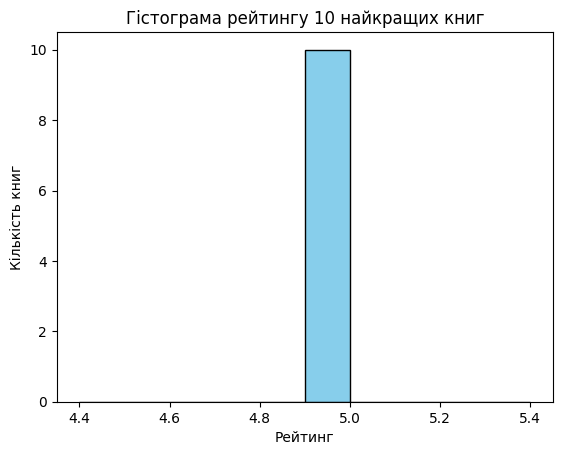

In [19]:
# Побудуйте гістограму рейтингу 10 найкращих книг
top_10_books = df.orderBy(df['user_rating'].desc()).limit(10).toPandas()
plt.hist(top_10_books['user_rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Гістограма рейтингу 10 найкращих книг')
plt.xlabel('Рейтинг')
plt.ylabel('Кількість книг')
plt.show()

In [26]:
# Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'
# Об'єднуємо потрібні стовпці в вектор
assembler = VectorAssembler(inputCols=['user_rating', 'reviews', 'price'], outputCol='features')
df_vector = assembler.transform(df).select('features')

# Обчислюємо матрицю кореляції
correlation_matrix = Correlation.corr(df_vector, 'features').head()
correlation_array = correlation_matrix[0].toArray()

print("\nМатриця кореляції:")
print(correlation_array)


Матриця кореляції:
[[ 1.         -0.00172901 -0.13308629]
 [-0.00172901  1.         -0.10918188]
 [-0.13308629 -0.10918188  1.        ]]


In [27]:
spark.stop()

# Висновок

В цій роботі ми досліджували датасет "Amazon Top 50 Bestselling Books 2009 – 2019". Після завантаження даних та їх перегляду, ми виконали ряд завдань для аналізу та підготовки даних для подальшого використання.

Спочатку ми прочитали CSV файл та вивели загальну структуру даних, включаючи схему, назви стовпців та їх типи. Після цього ми ознайомилися з першими рядками даних та провели описову статистику, використовуючи метод describe(). Ми також перевірили загальну кількість рядків та впевнилися, що в кожному рядку є достатньо даних.

Одним з важливих кроків було заповнення пропущених значень. Ми замінили їх на середні значення за відповідними стовпцями та переконалися, що тип даних відповідає потрібному формату.

Далі ми перейшли до аналізу даних, змінивши назви колонок та виконавши кілька запитів, щоб знайти автора з найвищим та найнижчим рейтингом, а також автора з найбільшою кількістю рецензій.

Завершальними кроками було побудовано гістограму рейтингу для 10 книг з найвищим рейтингом та матрицю кореляції для стовпців 'user_rating', 'reviews' та 'price', щоб вивчити зв'язки між цими параметрами.

У цілому, аналіз даних дозволив нам отримати більше інформації про набір даних та підготувати його для можливого подальшого використання в аналітичних або модельних дослідженнях.